# Voice anonymization project 🎤🎭

### Setting up some libraries, params, and utility variables

In [1]:
# The dataset_name variable will be the name we give to the EmoDB dataset once we download it.
# Just a friendly label to recognize it easily when we work with it later on.
dataset_name = "paido_dataset" #"kennedy_james_dataset" #"paido_dataset"
# anonymization_tool_name holds the enchanting name of our magical tool, "coqui."
# "coqui" will help us weave the cloak of anonymity around the voices.
# It's like the sorcerer behind the voice masks!
anonymization_tool_name = "coqui"
# The target_speaker_for_anonymization_file variable holds the file name of our protagonist.
# The brave "matt_male_adult_narakeet.wav" will undergo the voice anonymization process.
# We're about to witness a transformation like no other!
target_speaker_for_anonymization_file = "timmy_child_narakeet.wav"

In [2]:
# This variable holds the web address from which we'll download the EmoDB dataset.
# It's like a treasure map guiding us to the wonderful voice recordings!
#dataset_url = "http://emodb.bilderbar.info/download/download.zip"

# The data_folder variable points to the location where we'll store all the data and audio recordings.
# Think of it as our backstage area, well-organized and ready to showcase the talents of our voices!
data_folder = "../data/"

audio_folder_name = "original_audio_segments"

# target_speakers_for_anonymization_folder represents the folder where we'll keep the chosen speakers.
# These speakers are ready to be anonymized, like a room filled with intriguing characters,
# waiting for their secret identities!
target_speakers_for_anonymization_folder = "target_speakers_for_anonymization/"

In [3]:
# Let's import some essential libraries that will assist us in our voice anonymization journey.
import os
import pandas as pd
import numpy as np
import torchaudio
import torch
import sys
import pathlib
from speechbrain.utils.metric_stats import EER
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, Audio
import random
import string
import logging
from jiwer import wer
from statistics import mean, stdev
import contractions
from num2words import num2words
import re

main_folder = "../../.."
sys.path.append(main_folder)

# Next, we import the AudioRepresentation class from the audio_representation module.
from tools.audio_representation import AudioRepresentation

# Now, let's import the VoiceAnonymizer class from the anonymizer module.
from tools.voice_anonymization import VoiceAnonymizer

# Next, we import the Transcriber class from the speech_to_text module.
from tools.speech_to_text import Transcriber

# Next, we start initializing some variables.
# target_speaker_file_path points to the audio file of our chosen speaker for anonymization.
target_speaker_file_path = data_folder + target_speakers_for_anonymization_folder + target_speaker_for_anonymization_file

# output_folder is where we'll save the output plots and results later on.
output_folder = data_folder + "output/"

# We create the data_folder if it doesn't exist yet, to ensure we have a neat place to store data.
pathlib.Path(data_folder).mkdir(parents=True, exist_ok=True)

# dataset_path holds the path to our downloaded EmoDB dataset.
dataset_path = data_folder + dataset_name

# audio_folder_path points to the folder containing the original audio recordings in the EmoDB dataset.
audio_folder_path = f"{dataset_path}/{audio_folder_name}"

# anonymized_audio_folder_path is where we'll save the anonymized audio recordings.
# We'll create a new folder specific to the anonymization tool used for clarity.
anonymized_audio_folder_path = dataset_path + f"/anonymized_{anonymization_tool_name}_{audio_folder_name}/"

# Finally, we set some environment variables, just to have them accessible throughout our code.
#os.environ['dataset_url'] = dataset_url
os.environ['data_folder'] = data_folder
os.environ['dataset_name'] = dataset_name
os.environ['dataset_path'] = dataset_path

# Suppress debug messages
logging.getLogger('matplotlib.font_manager').disabled = True


DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7
DEBUG:h5py._conv:Creating converter from 7 to 5
DEBUG:h5py._conv:Creating converter from 5 to 7


### Setting up the dataset

In [4]:
# This function, get_random_file_from_folder, takes a folder_path as input.
# It returns the name of a random file from the specified folder.

def get_random_file_from_folder(folder_path):
    # Use the os.listdir() function to obtain a list of all files in the folder_path.
    files = os.listdir(folder_path)

    random_file = ""
    while not random_file.endswith(".wav"):
        # Randomly select a file from the list of files using random.choice().
        random_file = random.choice(files)

    # Return the name of the randomly selected file.
    return random_file

# The load_audio function loads an audio file using torchaudio and returns the waveform and sample rate.
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform, sample_rate

def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [5]:
# We'll use the previously defined function, get_random_file_from_folder, to obtain a random audio file name.
# The function takes the audio_folder_path as input and returns the name of a random file from the folder.

random_original_file = get_random_file_from_folder(audio_folder_path)

audio_waveform, sample_rate = load_audio(f"{audio_folder_path}/{random_original_file}")

# Now, we play the randomly selected audio file using the Audio() function.
# The Audio() function takes the complete path to the audio file as input.
# The path is created by concatenating the audio_folder_path and the randomly selected file name (random_original_file).

play_audio(audio_waveform, sample_rate)

### Anonymizing the voice in the dataset

In [6]:
# The following code plays the audio file of our chosen target speaker.
# The brave "matt_male_adult_narakeet.wav" will be anonymized with our coqui voice cloning.

# Using the Audio() function, we play the audio file located at the target_speaker_file_path.
# This will allow us to hear the original voice of our target speaker before the anonymization process.

audio_waveform, sample_rate = load_audio(target_speaker_file_path)

# Now, we play the randomly selected audio file using the Audio() function.
# The Audio() function takes the complete path to the audio file as input.
# The path is created by concatenating the audio_folder_path and the randomly selected file name (random_original_file).

play_audio(audio_waveform, sample_rate)

In [7]:
# The following function, anonymize_audio_files_in_folder, performs the magical voice anonymization process using the coqui voice cloning model.
import json
import ast
def anonymize_audio_files_in_folder(tool_name, path_to_audio_folder, path_to_anonymized_audio_folder, target_speaker_file_path):
    # We start by initializing three empty lists to hold information about the audio files.
    source_files = []  # List to store paths of original audio files to be anonymized.
    target_files = []  # List to store paths of the synthetic target speaker's audio file.
    output_files = []  # List to store paths where the anonymized audio files will be saved.

    # Create a VoiceAnonymizer object, named anonymizer, which will perform the voice anonymization.
    anonymizer = VoiceAnonymizer(method=tool_name)

    # Loop through all files in the specified audio folder (path_to_audio_folder).
    for file_name in os.listdir(path_to_audio_folder):
        # Check if the file has a ".wav" extension, indicating an audio file.
        if file_name.endswith(".wav"):
            # Obtain the full path of the audio file.
            file_path = os.path.join(path_to_audio_folder, file_name)

            # Create the corresponding path for the anonymized audio file.
            anonymized_file_path = file_path.replace(path_to_audio_folder, path_to_anonymized_audio_folder)

            # If the anonymized audio file doesn't exist, proceed with the anonymization process.
            if not os.path.exists(anonymized_file_path):
                # Create the necessary directories to store the anonymized audio file.
                pathlib.Path(os.path.dirname(anonymized_file_path)).mkdir(parents=True, exist_ok=True)

                # Add information about the audio files to their respective lists.
                source_files.append(file_path)  # Original audio file to be anonymized.
                target_files.append(target_speaker_file_path)  # Synthetic target speaker's audio file.
                output_files.append(anonymized_file_path)  # Path to save the anonymized audio file.

    # If there are audio files to be anonymized, call the anonymizer.anonymize() method.
    if len(source_files) > 0:
        anonymizer.anonymize(source_files=source_files, target_files=target_files, output_files=output_files)

In [8]:
# The following code invokes the function anonymize_audio_files_in_folder to perform the voice anonymization.

# The function is called with the following arguments:
# - anonymization_tool_name: The name of the tool to use for anonymization (in this case, "coqui").
# - audio_folder_path: The path to the folder containing the original audio recordings in the EmoDB dataset.
# - anonymized_audio_folder_path: The path where the anonymized audio recordings will be saved.
# - target_speaker_file_path: The path to the audio file of our chosen target speaker ("matt_male_adult_narakeet.wav").

anonymize_audio_files_in_folder(anonymization_tool_name, audio_folder_path, anonymized_audio_folder_path, target_speaker_file_path)

def process_audio_file(file_path):
    # Load the audio file
    waveform, sample_rate = torchaudio.load(file_path)

    # Check if the audio is stereo, and convert it to mono by taking the left channel
    if waveform.size(0) == 2:
        waveform = waveform[0:1, :]  # Take the left channel

    # Check the sample rate and resample to 16kHz if needed
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)

    # Save the processed waveform as a WAV file with the same file path
    torchaudio.save(file_path, waveform, 16000, encoding="PCM_S", bits_per_sample=16)

    #print(f"Processed audio saved at: {save_path}")

def get_wav_files_in_folder(folder_path):
    wav_files = []
    for dirpath, _, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.lower().endswith('.wav'):
                file_path = os.path.join(dirpath, filename)
                wav_files.append(file_path)
    return wav_files

wav_files = get_wav_files_in_folder(anonymized_audio_folder_path)
for file in wav_files:
    process_audio_file(file)

 > voice_conversion_models/multilingual/vctk/freevc24 is already downloaded.
DEBUG:fsspec.local:open file: /Users/fabiocat/Library/Application Support/tts/voice_conversion_models--multilingual--vctk--freevc24/config.json
 > Using model: freevc
 > Loading pretrained speaker encoder model ...
DEBUG:asyncio:Using selector: KqueueSelector
DEBUG:fsspec.cached:Opening local copy of https://github.com/coqui-ai/TTS/releases/download/v0.13.0_models/speaker_encoder.pt
Loaded the voice encoder model on cpu in 0.04 seconds.
INFO:TTS.vc.modules.freevc.wavlm.wavlm:WavLM Config: {'extractor_mode': 'layer_norm', 'encoder_layers': 24, 'encoder_embed_dim': 1024, 'encoder_ffn_embed_dim': 4096, 'encoder_attention_heads': 16, 'activation_fn': 'gelu', 'layer_norm_first': True, 'conv_feature_layers': '[(512,10,5)] + [(512,3,2)] * 4 + [(512,2,2)] * 2', 'conv_bias': False, 'feature_grad_mult': 1.0, 'normalize': True, 'dropout': 0.0, 'attention_dropout': 0.0, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.0,

In [9]:
# The following code plays the anonymized audio version of a random audio file from the EmoDB dataset.

# Using the Audio() function, we play the anonymized audio file located at the specified path.
# The path to the anonymized audio file is created by concatenating the anonymized_audio_folder_path and the random_original_file.

audio_waveform, sample_rate = load_audio(f"{anonymized_audio_folder_path}/{random_original_file}")

# Now, we play the randomly selected audio file using the Audio() function.
# The Audio() function takes the complete path to the audio file as input.
# The path is created by concatenating the audio_folder_path and the randomly selected file name (random_original_file).

play_audio(audio_waveform, sample_rate)

### Evaluating voice anonymization based on the achieved privacy and utility

In [10]:
# utilities

# Create an AudioRepresentation object, audio_repr, using the "EcapaTDNN" model.
audio_repr = AudioRepresentation(model_name="EcapaTDNN")

# The extract_embeddings function takes an input waveform and returns the corresponding speaker embeddings.
# It uses the audio_repr object to obtain the filtered_encoder_response for the input waveform.
def extract_embeddings(input_waveform):
    raw_encoder_response, filtered_encoder_response = audio_repr.contextual_encoding(input_waveform)
    return filtered_encoder_response

def replace_numbers_with_words(input_str):
    def replace_number(match):
        numeric_part = match.group()
        return num2words(int(numeric_part))

    # Use regular expression to find the numeric part of the input string and replace with words
    result = re.sub(r'\d+', replace_number, input_str)
    return result

def remove_punctuation_and_lower(text):
    # Convert the text to lowercase
    text = text.replace("_", " ")
    text = replace_numbers_with_words(text)
    text = text.lower()    
    text = contractions.fix(text)
    text = text.replace("'", "").strip()  
    text = ''.join(char for char in text if char not in string.punctuation)
    return text

def get_filename(row):
    return os.path.basename(row['path_to_audio_segment_file'])

# The process_files_to_embeddings function processes all the audio files in a given folder to extract speaker embeddings.
# It loads the audio files, groups them by speaker, and then computes the speaker embeddings for each speaker group.
def process_files_to_embeddings_and_transcripts(path_to_audio_folder, handmade_transcript_available=False):
    if handmade_transcript_available:
        xlsx_file_path = os.path.join(path_to_audio_folder, "overall_original.xlsx")
        xlsx_file_path_raw = os.path.join(path_to_audio_folder, "overall_original_raw.xlsx")
    else:
        xlsx_file_path = os.path.join(path_to_audio_folder, "overall_anonymized.xlsx")
        xlsx_file_path_raw = os.path.join(path_to_audio_folder, "overall_anonymized_raw.xlsx")
    
    print("xlsx_file_path")
    print(xlsx_file_path)
    if os.path.exists(xlsx_file_path):
        print('xlsx file already exists')
        
        df = pd.read_excel(xlsx_file_path, index_col=None)
        df['Embeddings'] = df['Embeddings'].apply(ast.literal_eval)
        df.fillna("", inplace=True)
        
        df_raw = pd.read_excel(xlsx_file_path_raw, index_col=None)
        df_raw['Embeddings'] = df_raw['Embeddings'].apply(ast.literal_eval)
        df_raw.fillna("", inplace=True)
    else:
        print('xlsx file does not exist')
        if handmade_transcript_available:
            df = pd.read_excel(os.path.join(path_to_audio_folder, 'segments.xlsx'), engine='openpyxl')
            df['audio_segment_file_base_name'] = df.apply(get_filename, axis=1)

        whisper_transcriber = Transcriber(
            model_name='whisper',
            model_checkpoint=None,
            language="english", 
            models_save_dir=None,
            extra_params=None,
        )

        mms_transcriber = Transcriber(
            model_name='mms',
            model_checkpoint=None,
            language="eng", # TO DO!!!
            models_save_dir=None,
            extra_params=None,
        )
        
        file_details = []
        for file_name in os.listdir(path_to_audio_folder):

            if file_name.endswith(".wav"):
                print(file_name)
                file_path = os.path.join(path_to_audio_folder, file_name)
                waveform, sr = load_audio(file_path)
                speaker = file_name.split("_")[0]

                raw_response, whisper_text = whisper_transcriber.transcribe(waveform)
                
                print("\n")

                if whisper_text is None:
                    whisper_text = ""
                else:
                    whisper_text = remove_punctuation_and_lower(whisper_text[0])
                    #print("whisper_text")
                    print(whisper_text)
                raw_response, mms_text = mms_transcriber.transcribe(waveform)
                if mms_text is None:
                    mms_text = ""
                else:
                    mms_text = remove_punctuation_and_lower(mms_text[0])
                    #print("mms_text")
                    print(mms_text)

                if handmade_transcript_available:
                    transcript = remove_punctuation_and_lower(df.loc[df['audio_segment_file_base_name'] == file_name, 'text'].values[0])
                    print(transcript)
                    file_details.append([file_path, file_name, speaker, waveform.squeeze(), transcript, whisper_text, mms_text])
                else:
                    file_details.append([file_path, file_name, speaker, waveform.squeeze(), whisper_text, mms_text])

        if handmade_transcript_available:
            df = pd.DataFrame(file_details, columns=["Path", "Name", "Speaker", "Waveform", "Handmade transcript", "Whisper transcript", "MMS transcript"])
        else:
            df = pd.DataFrame(file_details, columns=["Path", "Name", "Speaker", "Waveform", "Whisper transcript", "MMS transcript"])
        df_raw = df
        
        if handmade_transcript_available:            
            # Create a new DataFrame with concatenated Waveform values grouped by Speaker
            df_waveform = pd.DataFrame(df.groupby('Speaker', sort=False)['Waveform'].agg(lambda x: np.concatenate(x.values)), columns=['Waveform']).reset_index()

            # Create a new DataFrame with concatenated Transcript values grouped by Speaker
            df_transcript = pd.DataFrame(df.groupby('Speaker', sort=False)['Handmade transcript'].agg(lambda x: " ".join(x)), columns=['Handmade transcript']).reset_index()

            # Create a new DataFrame with concatenated Transcript values grouped by Speaker
            df_transcript_whisper = pd.DataFrame(df.groupby('Speaker', sort=False)['Whisper transcript'].agg(lambda x: " ".join(x)), columns=['Whisper transcript']).reset_index()

            # Create a new DataFrame with concatenated Transcript values grouped by Speaker
            df_transcript_mms = pd.DataFrame(df.groupby('Speaker', sort=False)['MMS transcript'].agg(lambda x: " ".join(x)), columns=['MMS transcript']).reset_index()

            # Merge the two DataFrames on the 'Speaker' column
            df = pd.merge(df_waveform, df_transcript, on='Speaker')
            df = pd.merge(df, df_transcript_whisper, on='Speaker')
            df = pd.merge(df, df_transcript_mms, on='Speaker')
        else:
            df_waveform = pd.DataFrame(df.groupby('Speaker', sort=False)['Waveform'].agg(lambda x: np.concatenate(x.values)), columns=['Waveform']).reset_index()
            # Create a new DataFrame with concatenated Transcript values grouped by Speaker
            df_transcript_whisper = pd.DataFrame(df.groupby('Speaker', sort=False)['Whisper transcript'].agg(lambda x: " ".join(x)), columns=['Whisper transcript']).reset_index()

            # Create a new DataFrame with concatenated Transcript values grouped by Speaker
            df_transcript_mms = pd.DataFrame(df.groupby('Speaker', sort=False)['MMS transcript'].agg(lambda x: " ".join(x)), columns=['MMS transcript']).reset_index()

            # Merge the two DataFrames on the 'Speaker' column
            df = pd.merge(df_waveform, df_transcript_whisper, on='Speaker')
            df = pd.merge(df, df_transcript_mms, on='Speaker')

        all_embeddings = []
        for index, row in df.iterrows():
            waveform = row['Waveform']
            embeddings = extract_embeddings(torch.tensor(waveform))
            all_embeddings.append(embeddings.squeeze())
        
        df['Embeddings'] = [embedding.tolist() for embedding in all_embeddings]
        df['Embeddings'] = df['Embeddings'].apply(json.dumps)
        df.to_excel(xlsx_file_path, index=None)  
        df['Embeddings'] = df['Embeddings'].apply(ast.literal_eval)
        df.fillna("", inplace=True)
        
        all_embeddings = []
        for index, row in df_raw.iterrows():
            waveform = row['Waveform']
            embeddings = extract_embeddings(torch.tensor(waveform))
            all_embeddings.append(embeddings.squeeze())
        
        df_raw['Embeddings'] = [embedding.tolist() for embedding in all_embeddings]
        df_raw['Embeddings'] = df_raw['Embeddings'].apply(json.dumps)
        df_raw.to_excel(xlsx_file_path_raw, index=None)  
        df_raw['Embeddings'] = df_raw['Embeddings'].apply(ast.literal_eval)
        df_raw.fillna("", inplace=True)
    return df, df_raw


# The compute_similarity_score function computes the cosine similarity score between two speaker embeddings.
# It uses the torch.nn.CosineSimilarity to perform the cosine similarity computation.
def compute_similarity_score(embedding1, embedding2):
    cos = torch.nn.CosineSimilarity(dim=-1)
    similarity_score = cos(torch.tensor(embedding1), torch.tensor(embedding2))
    return similarity_score.item()

# The compute_eer_and_plot_verification_scores function compares embeddings and computes the Equal Error Rate (EER).
# It also creates a histogram plot with the verification scores.
def compute_eer_and_plot_verification_scores(df1, df2, label_df1, label_df2, raw):
    df_rows = []
    for i, row1 in df1.iterrows():
        for j, row2 in df2.iterrows():
            s1 = row1['Speaker']
            s2 = row2['Speaker']
            e1 = row1['Embeddings']
            e2 = row2['Embeddings']
            cosine = compute_similarity_score(e1, e2)
            if s1 == s2:
                same = 1
            else:
                same = 0
            df_rows.append([s1, s2, e1, e2, cosine, same])

    df_pairs = pd.DataFrame(df_rows, columns=['Speaker 1', 'Speaker 2', 'Embeddings 1', 'Embeddings 2', 'Cosine distance', 'Same'])

    positive_scores = df_pairs.loc[df_pairs['Same'] == True]['Cosine distance'].values
    negative_scores = df_pairs.loc[df_pairs['Same'] == False]['Cosine distance'].values
    eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    plt.figure()
    ax = sns.histplot(df_pairs, x='Cosine distance', hue='Same', stat='percent', common_norm=False)
    ax.set_title(f'EER={round(eer, 4)} - Thresh={round(threshold, 4)}')
    plt.axvline(x=[threshold], color='red', ls='--')

    pathlib.Path(output_folder + dataset_name).mkdir(parents=True, exist_ok=True)
    if raw:
        plot_path = output_folder + dataset_name + f'/EER_raw_{anonymization_tool_name}_{dataset_name}_{target_speaker_for_anonymization_file[:-4]}_{label_df1}_{label_df2}.png'
    else:
        plot_path = output_folder + dataset_name + f'/EER_{anonymization_tool_name}_{dataset_name}_{target_speaker_for_anonymization_file[:-4]}_{label_df1}_{label_df2}.png'

    plt.savefig(plot_path, format='png')
    return plot_path

INFO:speechbrain.pretrained.fetching:Fetch hyperparams.yaml: Using existing file/symlink in /Users/fabiocat/Documents/git/fab/tools/audio_representation/tools/../pretrained_models/speechbrain_spkrec-ecapa-voxceleb/hyperparams.yaml.
INFO:speechbrain.pretrained.fetching:Fetch custom.py: Delegating to Huggingface hub, source speechbrain/spkrec-ecapa-voxceleb.
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /speechbrain/spkrec-ecapa-voxceleb/resolve/main/custom.py HTTP/1.1" 404 0
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _load
DEBUG:speechbrain.utils.checkpoints:Registered parameter transfer hook for _load
DEBUG:speechbrain.utils.parameter_transfer:Collecting files (or symlinks) for pretraining in /Users/fabiocat/Documents/git/fab/tools/audio_representation/tools/../pretrained_models/spee

In [11]:
# The following code processes the audio files in the specified audio_folder_path
# and extracts speaker embeddings for each speaker.

# Calling the process_files_to_embeddings function to obtain the DataFrame (df).
# This DataFrame (df) will contain the speaker embeddings for each speaker in the EmoDB dataset.
df, df_raw = process_files_to_embeddings_and_transcripts(audio_folder_path, handmade_transcript_available=True)

# The DataFrame (df) contains the following columns:
# - "Speaker": The unique identifier of the speaker.
# - "Waveform": Concatenated waveform of all audio recordings from the same speaker.
# - "Embeddings": Speaker embeddings extracted from the concatenated waveform.

xlsx_file_path
../data/paido_dataset/original_audio_segments/overall_original.xlsx
xlsx file already exists


In [12]:
# The DataFrame (df) holds the magical speaker embeddings, ready for our evaluation journey!
df

,Speaker,Waveform,Handmade transcript,Whisper transcript,MMS transcript,Embeddings
0,e2at01f322,[ 0. 0. 0. ... -0.00...,cupid,stupid,je bi,"[-18.674102783203125, 53.704627990722656, -30...."
1,e2at01f321,[0.0000000e+00 0.0000000e+00 0.0000000e+00 ......,car tooth,hi cheers,a gie sa,"[-6.445933818817139, 13.635686874389648, -18.3..."


In [13]:
# The DataFrame (df) holds the magical speaker embeddings, ready for our evaluation journey!
df_raw

,Path,Name,Speaker,Waveform,Handmade transcript,Whisper transcript,MMS transcript,Embeddings
0,../data/paido_dataset/original_audio_segments/...,e2at01f322_773926_775177.wav,e2at01f322,"tensor([ 0.0000, 0.0000, 0.0000, ..., -0.00...",cupid,stupid,je bi,"[-18.674102783203125, 53.704627990722656, -30...."
1,../data/paido_dataset/original_audio_segments/...,e2at01f321_24532_25179.wav,e2at01f321,"tensor([ 0.0000, 0.0000, 0.0000, ..., -0.00...",car,hi,,"[-19.072345733642578, -35.70865249633789, -8.9..."
2,../data/paido_dataset/original_audio_segments/...,e2at01f321_31011_32096.wav,e2at01f321,"tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, ....",tooth,cheers,a gie sa,"[9.07609748840332, 43.825260162353516, -39.222..."


In [14]:
# The following code evaluates the Equal Error Rate (EER) for the original audio files,
# which means we are comparing each audio file to itself to see how similar they are.

# Calling the compute_eer_and_plot_verification_scores function with the DataFrame (df) as both input arguments.
# This function will compare the embeddings of each audio file to all other audio files in the DataFrame.
# The labels for the comparison will be set as "original" for both, as we are comparing the original audio files with themselves.
# The function will compute the EER and create a histogram plot with the verification scores.

# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(df, df, "original", "original", False)

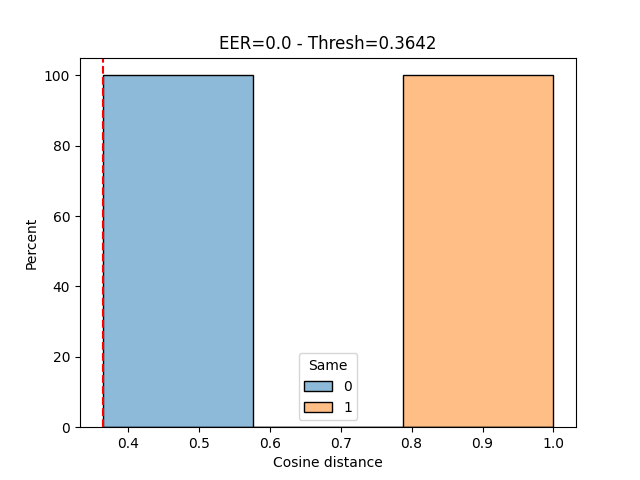

In [15]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison of audio files with themselves.
Image(filename=plot_path)

In [16]:
# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(df_raw, df_raw, "original", "original", True)

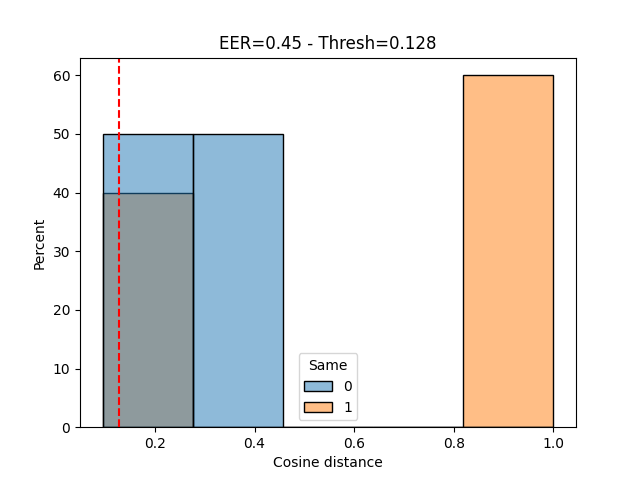

In [17]:
Image(filename=plot_path)

In [18]:
# The following code extracts Ecapa-TDNN speaker embeddings from the anonymized audio recordings
# and creates a DataFrame (anonymized_df) with the embeddings.

# Calling the process_files_to_embeddings function with the anonymized_audio_folder_path as input.
# This function will process the audio files in the anonymized_audio_folder_path and extract speaker embeddings for each speaker.
anonymized_df, anonymized_df_raw = process_files_to_embeddings_and_transcripts(anonymized_audio_folder_path)

# The DataFrame (anonymized_df) contains the following columns:
# - "Speaker": The unique identifier of the speaker.
# - "Waveform": Concatenated waveform of all anonymized audio recordings from the same speaker.
# - "Embeddings": Speaker embeddings extracted from the concatenated anonymized waveform.

xlsx_file_path
../data/paido_dataset/anonymized_coqui_original_audio_segments/overall_anonymized.xlsx
xlsx file does not exist
Model is multilingual and has 1,541,384,960 parameters.
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/mms-1b-all/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/mms-1b-all/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/mms-1b-all/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/mms-1b-all/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/mms-1b-all/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/mms-1b-all/resolve/main/adapter.eng.safetensors HTTP/1.1" 302 0
e2at01f322_7

In [19]:
# The DataFrame (anonymized_df) now holds the magical speaker embeddings for the anonymized audio clips.
# We're ready to compare them with the embeddings from the original audio clips to measure the distance!
anonymized_df

,Speaker,Waveform,Whisper transcript,MMS transcript,Embeddings
0,e2at01f322,"[-0.0020446777, -0.0018005371, -0.0034484863, ...",you,siail pi,"[-1.741774320602417, 48.8602294921875, -10.840..."
1,e2at01f321,"[-0.032836914, -0.046203613, -0.04852295, -0.0...",christ cheers,pri dies,"[11.256596565246582, 14.561393737792969, 5.569..."


In [20]:
# The DataFrame (anonymized_df) now holds the magical speaker embeddings for the anonymized audio clips.
# We're ready to compare them with the embeddings from the original audio clips to measure the distance!
anonymized_df_raw

,Path,Name,Speaker,Waveform,Whisper transcript,MMS transcript,Embeddings
0,../data/paido_dataset/anonymized_coqui_origina...,e2at01f322_773926_775177.wav,e2at01f322,"[tensor(-0.0020), tensor(-0.0018), tensor(-0.0...",you,siail pi,"[-1.741774320602417, 48.8602294921875, -10.840..."
1,../data/paido_dataset/anonymized_coqui_origina...,e2at01f321_24532_25179.wav,e2at01f321,"[tensor(-0.0328), tensor(-0.0462), tensor(-0.0...",christ,pri,"[3.629046678543091, 8.914152145385742, -2.2563..."
2,../data/paido_dataset/anonymized_coqui_origina...,e2at01f321_31011_32096.wav,e2at01f321,"[tensor(-0.0052), tensor(-0.0040), tensor(-0.0...",cheers,dies,"[3.599797010421753, 3.104788303375244, 5.50723..."


In [21]:
# The following code performs the Equal Error Rate (EER) computation
# between the embeddings of original and anonymized audio clips.

# Calling the compute_eer_and_plot_verification_scores function with two DataFrames, df and anonymized_df, as input arguments.
# The function will compare the embeddings of each audio file in df with all audio files in anonymized_df.
# We set the labels for the comparison as "original" for df and "anonymized" for anonymized_df.
# The function will compute the EER and create a histogram plot with the verification scores.

# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(df, anonymized_df, "original", "anonymized", False)

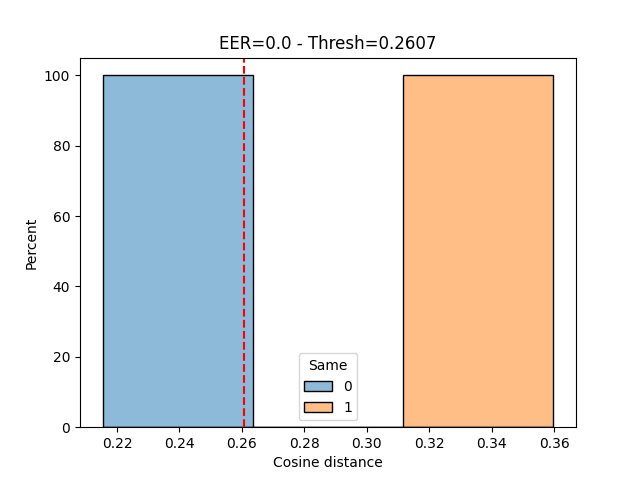

In [22]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison between original and anonymized audio clips.
Image(filename=plot_path)

In [23]:
# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(df_raw, anonymized_df_raw, "original", "anonymized", True)

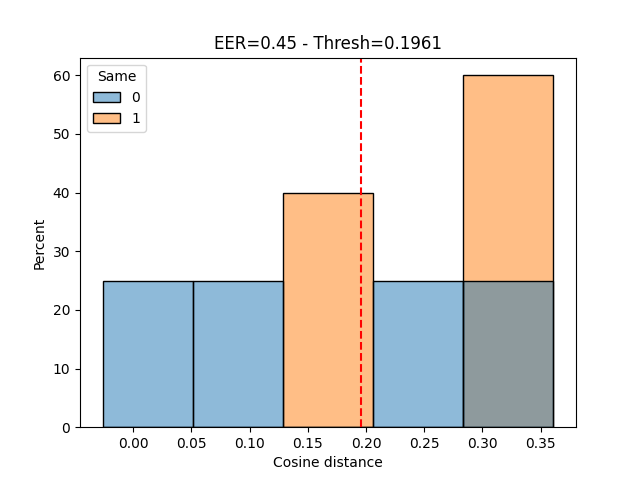

In [24]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison between original and anonymized audio clips.
Image(filename=plot_path)

In [25]:
# The following code performs the Equal Error Rate (EER) computation
# between the embeddings of anonymized audio clips, comparing each anonymized clip to itself.

# Calling the compute_eer_and_plot_verification_scores function with the anonymized_df DataFrame as both input arguments.
# The function will compare the embeddings of each audio file in anonymized_df with all other audio files in anonymized_df.
# We set the labels for the comparison as "anonymized" for both, as we are comparing anonymized clips with themselves.
# The function will compute the EER and create a histogram plot with the verification scores.

# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(anonymized_df, anonymized_df, "anonymized", "anonymized", False)

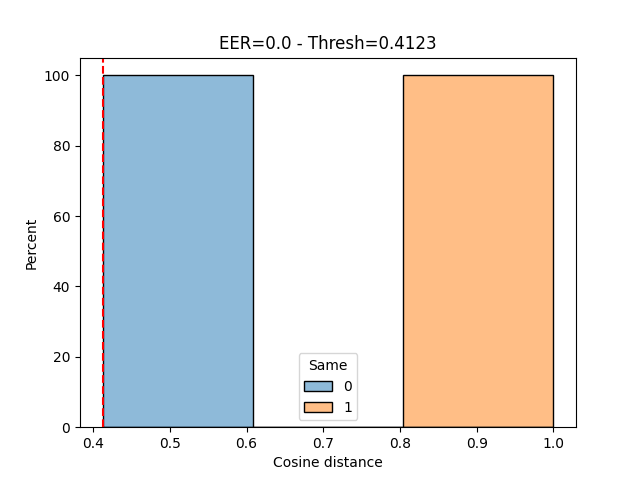

In [26]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison of anonymized audio clips with themselves.
Image(filename=plot_path)

In [27]:
# The following code performs the Equal Error Rate (EER) computation
# between the embeddings of anonymized audio clips, comparing each anonymized clip to itself.

# Calling the compute_eer_and_plot_verification_scores function with the anonymized_df DataFrame as both input arguments.
# The function will compare the embeddings of each audio file in anonymized_df with all other audio files in anonymized_df.
# We set the labels for the comparison as "anonymized" for both, as we are comparing anonymized clips with themselves.
# The function will compute the EER and create a histogram plot with the verification scores.

# The plot_path variable will store the path to the generated plot.
plot_path = compute_eer_and_plot_verification_scores(anonymized_df_raw, anonymized_df_raw, "anonymized", "anonymized", True)

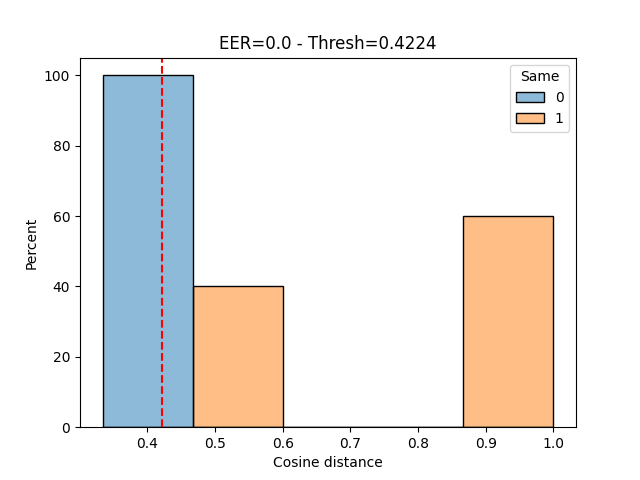

In [28]:
# Displaying the generated plot using the Image() function.
# The plot will show the verification scores and the EER for the comparison of anonymized audio clips with themselves.
Image(filename=plot_path)

In [29]:
def extract_detailed_WER(df, anonymized_df):
    h_vs_w__list = []
    h_vs_m__list = []
    h_vs_aw__list = []
    h_vs_am__list = []
    w_vs_aw__list = []
    m_vs_am__list = []
    for i, row in df.iterrows():
        handmade_transcript = row['Handmade transcript']
        whisper_transcript = row['Whisper transcript']
        mms_transcript = row['MMS transcript']
        anon_whisper_transcript = anonymized_df.loc[i, 'Whisper transcript']
        anon_mms_transcript = anonymized_df.loc[i, 'MMS transcript']
        
        '''
        print(handmade_transcript)
        print(whisper_transcript)
        print(mms_transcript)
        print(anon_whisper_transcript)
        print(anon_mms_transcript)
        '''
        
        h_vs_w = wer(handmade_transcript, whisper_transcript)
        h_vs_w__list.append(h_vs_w)
        h_vs_m = wer(handmade_transcript, mms_transcript)
        h_vs_m__list.append(h_vs_m)
        h_vs_aw = wer(handmade_transcript, anon_whisper_transcript)
        h_vs_aw__list.append(h_vs_aw)
        h_vs_am = wer(handmade_transcript, anon_mms_transcript)
        h_vs_am__list.append(h_vs_am)
        if whisper_transcript is None or whisper_transcript == "":
            w_vs_aw = 1 # work around, not really correct
        else:
            w_vs_aw = wer(whisper_transcript, anon_whisper_transcript)
        w_vs_aw__list.append(w_vs_aw)    
        if mms_transcript is None or mms_transcript == "":
            m_vs_am = 1 # work around, not really correct
        else:
            m_vs_am = wer(mms_transcript, anon_mms_transcript)
        m_vs_am__list.append(m_vs_am)
    
    h_vs_w__macro = mean(h_vs_w__list)
    h_vs_m__macro = mean(h_vs_m__list)
    h_vs_aw__macro = mean(h_vs_aw__list)
    h_vs_am__macro = mean(h_vs_am__list)
    w_vs_aw__macro = mean(w_vs_aw__list)
    m_vs_am__macro = mean(m_vs_am__list)
    
    h_vs_w__macro2 = stdev(h_vs_w__list)
    h_vs_m__macro2 = stdev(h_vs_m__list)
    h_vs_aw__macro2 = stdev(h_vs_aw__list)
    h_vs_am__macro2 = stdev(h_vs_am__list)
    w_vs_aw__macro2 = stdev(w_vs_aw__list)
    m_vs_am__macro2 = stdev(m_vs_am__list)
    
    return h_vs_w__list, h_vs_m__list, h_vs_aw__list, h_vs_am__list, w_vs_aw__list, m_vs_am__list, h_vs_w__macro, h_vs_w__macro2, h_vs_m__macro, h_vs_m__macro2, h_vs_aw__macro, h_vs_aw__macro2, h_vs_am__macro, h_vs_am__macro2, w_vs_aw__macro, w_vs_aw__macro2, m_vs_am__macro, m_vs_am__macro2
    '''
    print(mean(h_vs_w__list))
    print(mean(h_vs_m__list))
    print(mean(h_vs_aw__list))
    print(mean(h_vs_am__list))
    print(mean(w_vs_aw__list))
    print(mean(m_vs_am__list))
    '''

In [30]:
def extract_WER(df, anonymized_df, df_raw, anonymized_df_raw):
    pathlib.Path(output_folder + dataset_name).mkdir(parents=True, exist_ok=True)

    ### MICRO (one single number describing it all)
    handmade_transcript = " ".join(list(df['Handmade transcript']))
    whisper_transcript = " ".join(list(df['Whisper transcript']))
    mms_transcript = " ".join(list(df['MMS transcript']))
    
    h_vs_w = wer(handmade_transcript, whisper_transcript)
    h_vs_m = wer(handmade_transcript, mms_transcript)

    anon_whisper_transcript = " ".join(list(anonymized_df['Whisper transcript']))
    anon_mms_transcript = " ".join(list(anonymized_df['MMS transcript']))

    h_vs_aw = wer(handmade_transcript, anon_whisper_transcript)
    h_vs_am = wer(handmade_transcript, anon_mms_transcript)
    
    if whisper_transcript is None or whisper_transcript == "":
        w_vs_aw = 1 # work around, not really correct
    else:
        w_vs_aw = wer(whisper_transcript, anon_whisper_transcript)
    if mms_transcript is None or mms_transcript == "":
        m_vs_am = 1 # work around, not really correct
    else:
        m_vs_am = wer(mms_transcript, anon_mms_transcript)
    
    # MACRO 1 (per speaker)
    h_vs_w__list_speaker, h_vs_m__list_speaker, h_vs_aw__list_speaker, h_vs_am__list_speaker, w_vs_aw__list_speaker, m_vs_am__list_speaker, h_vs_w__macro_speaker, h_vs_w__macro2_speaker, h_vs_m__macro_speaker, h_vs_m__macro2_speaker, h_vs_aw__macro_speaker, h_vs_aw__macro2_speaker, h_vs_am__macro_speaker, h_vs_am__macro2_speaker, w_vs_aw__macro_speaker, w_vs_aw__macro2_speaker, m_vs_am__macro_speaker, m_vs_am__macro2_speaker = extract_detailed_WER(df, anonymized_df)
    xlsx_file_path = output_folder + dataset_name + f'/WER_speaker_details_{dataset_name}_{anonymization_tool_name}_{target_speaker_for_anonymization_file[:-4]}.xlsx'
    #my_df = pd.DataFrame([[h_vs_w__list_speaker, h_vs_m__list_speaker, h_vs_aw__list_speaker, h_vs_am__list_speaker, w_vs_aw__list_speaker, m_vs_am__list_speaker]], columns=["h_vs_w__list_speaker", "h_vs_m__list_speaker", "h_vs_aw__list_speaker", "h_vs_am__list_speaker", "w_vs_aw__list_speaker", "m_vs_am__list_speaker"])
    data = {
        "h_vs_w__list_speaker": h_vs_w__list_speaker,
        "h_vs_m__list_speaker": h_vs_m__list_speaker,
        "h_vs_aw__list_speaker": h_vs_aw__list_speaker,
        "h_vs_am__list_speaker": h_vs_am__list_speaker,
        "w_vs_aw__list_speaker": w_vs_aw__list_speaker,
        "m_vs_am__list_speaker": m_vs_am__list_speaker
    }
    my_df = pd.DataFrame(data)
    my_df.to_excel(xlsx_file_path, index=None)  

    # MACRO 2 (per audio)
    h_vs_w__list_audio, h_vs_m__list_audio, h_vs_aw__list_audio, h_vs_am__list_audio, w_vs_aw__list_audio, m_vs_am__list_audio, h_vs_w__macro_audio, h_vs_w__macro2_audio, h_vs_m__macro_audio, h_vs_m__macro2_audio, h_vs_aw__macro_audio, h_vs_aw__macro2_audio, h_vs_am__macro_audio, h_vs_am__macro2_audio, w_vs_aw__macro_audio, w_vs_aw__macro2_audio, m_vs_am__macro_audio, m_vs_am__macro2_audio = extract_detailed_WER(df_raw, anonymized_df_raw)
    xlsx_file_path = output_folder + dataset_name + f'/WER_audio_details_{dataset_name}_{anonymization_tool_name}_{target_speaker_for_anonymization_file[:-4]}.xlsx'
    #my_df = pd.DataFrame([[h_vs_w__list_audio, h_vs_m__list_audio, h_vs_aw__list_audio, h_vs_am__list_audio, w_vs_aw__list_audio, m_vs_am__list_audio]], columns=["h_vs_w__list_audio", "h_vs_m__list_audio", "h_vs_aw__list_audio", "h_vs_am__list_audio", "w_vs_aw__list_audio", "m_vs_am__list_audio"])
    data = {
        "h_vs_w__list_audio": h_vs_w__list_audio,
        "h_vs_m__list_audio": h_vs_m__list_audio,
        "h_vs_aw__list_audio": h_vs_aw__list_audio,
        "h_vs_am__list_audio": h_vs_am__list_audio,
        "w_vs_aw__list_audio": w_vs_aw__list_audio,
        "m_vs_am__list_audio": m_vs_am__list_audio
    }
    my_df = pd.DataFrame(data) 
    my_df.to_excel(xlsx_file_path, index=None)  
    
    # OVERALL
    xlsx_file_path = output_folder + dataset_name + f'/WER_overall_{dataset_name}_{anonymization_tool_name}_{target_speaker_for_anonymization_file[:-4]}.xlsx'
    my_df = pd.DataFrame([{"h_vs_w": h_vs_w,
                         "h_vs_m": h_vs_m,
                         "h_vs_aw": h_vs_aw,
                         "h_vs_am": h_vs_am,
                         "w_vs_aw": w_vs_aw,
                         "m_vs_am": m_vs_am,
                         "h_vs_w__macro_speaker": h_vs_w__macro_speaker,
                         "h_vs_w__macro2_speaker": h_vs_w__macro2_speaker,
                         "h_vs_m__macro_speaker": h_vs_m__macro_speaker,
                         "h_vs_m__macro2_speaker": h_vs_m__macro2_speaker,
                         "h_vs_aw__macro_speaker": h_vs_aw__macro_speaker,
                         "h_vs_aw__macro2_speaker": h_vs_aw__macro2_speaker,
                         "h_vs_am__macro_speaker": h_vs_am__macro_speaker,
                         "h_vs_am__macro2_speaker": h_vs_am__macro2_speaker,
                         "w_vs_aw__macro_speaker": w_vs_aw__macro_speaker,
                         "w_vs_aw__macro2_speaker": w_vs_aw__macro2_speaker,
                         "m_vs_am__macro_speaker": m_vs_am__macro_speaker,
                         "m_vs_am__macro2_speaker": m_vs_am__macro2_speaker,
                         "h_vs_w__macro_audio": h_vs_w__macro_audio,
                         "h_vs_w__macro2_audio": h_vs_w__macro2_audio,
                         "h_vs_m__macro_audio": h_vs_m__macro_audio,
                         "h_vs_m__macro2_audio": h_vs_m__macro2_audio,
                         "h_vs_aw__macro_audio": h_vs_aw__macro_audio,
                         "h_vs_aw__macro2_audio": h_vs_aw__macro2_audio,
                         "h_vs_am__macro_audio": h_vs_am__macro_audio,
                         "h_vs_am__macro2_audio": h_vs_am__macro2_audio,
                         "w_vs_aw__macro_audio": w_vs_aw__macro_audio,
                         "w_vs_aw__macro2_audio": w_vs_aw__macro2_audio,
                         "m_vs_am__macro_audio": m_vs_am__macro_audio, 
                         "m_vs_am__macro2_audio": m_vs_am__macro2_audio 
                         }])
    
    my_df.to_excel(xlsx_file_path, index=None)  
    return my_df

In [31]:
extract_WER(df, anonymized_df, df_raw, anonymized_df_raw)

,h_vs_w,h_vs_m,h_vs_aw,h_vs_am,w_vs_aw,m_vs_am,h_vs_w__macro_speaker,h_vs_w__macro2_speaker,h_vs_m__macro_speaker,h_vs_m__macro2_speaker,...,h_vs_m__macro_audio,h_vs_m__macro2_audio,h_vs_aw__macro_audio,h_vs_aw__macro2_audio,h_vs_am__macro_audio,h_vs_am__macro2_audio,w_vs_aw__macro_audio,w_vs_aw__macro2_audio,m_vs_am__macro_audio,m_vs_am__macro2_audio
0,1.0,1.666667,1.0,1.333333,0.666667,1.0,1.0,0.0,1.75,0.353553,...,2.0,1.0,1.0,0.0,1.333333,0.57735,0.666667,0.57735,1.0,0.0
